In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from numba import njit

@njit
def initialize_plane(N):
    """initializes a matrix of zeros where the top row is 1"""

    #matrix of zeros of NxN
    plane = np.zeros((N,N))

    #first row contains ones
    plane[0] = np.ones(N)

    return plane

@njit
def initialize_sinks(N,sinks=0):
    """initializes a matrix of zeros where some areas are 1"""

    #plane of zeros 
    plane = np.zeros((N,N))

    #determine dimension of sink
    sink_size = int(N/10)

    #add one sink into the plane
    if sinks == 1:
        #sink in the middle of the plane
        plane[sink_size*4:sink_size*6,sink_size*4:sink_size*6] = 1
    
    #add two sinks into the plane
    if sinks == 2:
        plane[sink_size*6:sink_size*7,sink_size*7:sink_size*8] = 1
        plane[sink_size*2:sink_size*3,sink_size*2:sink_size*3] = 1
    
    return plane

@njit
def initialize_aggregate(N):
    """initializes a matrix of zeros where one cell on the bottom is 1"""

    #plane of zeros 
    plane = np.zeros((N,N))

    i = N-1
    j = int(N/2)
    #add the seed to the plane
    plane[i][j] = 1

    #add neighbors to the plane
    plane = update_candidates(plane,i,j)

    return plane

@njit
def update_candidates(aggregate,i,j):
    """defines the neighborhood for a given point,
     taking into account existing objects and boundary conditions
     """

    #add given indices to the aggregate
    aggregate[i][j] =1

    #get boundary
    N = len(aggregate)

    #check for left column boundary
    if j==0:
        #check left available
        if aggregate[i,N-1] == 0:
            aggregate[i,N-1] = .5
        #check right available
        if aggregate[i,j+1] == 0:
            aggregate[i,j+1] = .5

    #check for right column boundary
    elif j == N-1:
        #check left available
        if aggregate[i,j-1] == 0:
            aggregate[i,j-1] = .5
        #check right available
        if aggregate[i,0] == 0:
            aggregate[i,0] = .5

    #use normal neighbors      
    else:
        #check left available
        if aggregate[i,j-1] == 0:
            aggregate[i,j-1] = .5
        #check right available
        if aggregate[i,j+1] == 0:
            aggregate[i,j+1] = .5

    #check for upper row boundary
    if i==0:
        #check if down available
        if aggregate[i+1,j] == 0:
            aggregate[i+1,j] = 0.5

    #check for lower boundary
    elif i == N-1:
        #check if up available
        if aggregate[i-1,j] == 0:
            aggregate[i-1,j] = .5

    #use normal neighbors    
    else:
        #check if up available
        if aggregate[i-1,j] == 0:
            aggregate[i-1,j] = .5
        #check if down available
        if aggregate[i+1,j] == 0:
            aggregate[i+1,j] = .5

    return aggregate

@njit
def get_neighbors(i,j,N=100):
    """returns the neighbor indices of current location
    accounts for periodic boundaries
    """

    #empty array for neighbors (left,right,up,down)
    neighbors = np.array([[i,0],[i,0],[i-1,j],[i+1,j]])

    #check for left column boundary
    if j==0:
        #add left and right neighbor
        neighbors[0][1] = N-1
        neighbors[1][1] = j+1

    #check for right column boundary
    elif j == N-1:
        #add left and right neighbor
        neighbors[0][1] = j-1
        neighbors[1][1] = 0

    #use normal neighbors      
    else:
        #add left and right neigbhor
        neighbors[0][1] = j-1
        neighbors[1][1] = j+1
        
    return neighbors


#@njit #doesn't work because of np.random?
def random_walk(new_aggregate,stick_p=1,probs=[0.25,0.25,0.25,0.25],seed=None):
    """releases a single random walker on plane that sticks to encountered objects
    Returns the new state of the plane
    """
    #condition for the while loop
    running = True

    #width of the plane
    N = len(new_aggregate)

    #pick a random column to start
    j = np.random.randint(0,N)

    #initial position of row is 0
    i = 0

    #while the walker is within bounds
    while running:
        #check if current position is next to object
        if new_aggregate[i][j]==0.5: 

            #stick with probability p to aggregate
            if np.random.uniform() < stick_p:
                #stick to the object and update neighboorhood of object
                new_aggregate = update_candidates(new_aggregate,i,j)

                #end the loop
                running = False
            else: 
                #define the neighborhood of the position
                neighbors = get_neighbors(i,j,N)

                #pick a random position
                chosen = np.random.choice(np.arange(0,4), p=probs)
                
                #check if walker out of bounds
                if neighbors[chosen][0] < 0 or neighbors[chosen][0] > N-1:
                    #end the loop
                    running = False
                else:
                    #move walker to new position
                    i = neighbors[chosen][0]
                    j = neighbors[chosen][1]
        else:
            #define the neighborhood of the position
            neighbors = get_neighbors(i,j,N)

            #pick a random position
            chosen = np.random.choice(np.arange(0,4), p=probs)
            
            #check if walker out of bounds
            if neighbors[chosen][0] < 0 or neighbors[chosen][0] > N-1:
                #end the loop
                running = False
            else:
                #move walker to new position
                i = neighbors[chosen][0]
                j = neighbors[chosen][1]

    return new_aggregate

#@njit #doesn't work because of np.random?
def simulate_MCDLA(N=100,stick_p=1,seed=None,probs=[0.25,0.25,0.25,0.25]):
    """simulates Diffusion Limited Aggregation using random walkers
    Returns the final state of the system as diffusion field and aggregate
    """
    #set random seed for testing
    np.random.seed(seed)

    #initialize aggregate
    new_aggregate = initialize_aggregate(N)

    #grow the aggregate until it has reached the source
    while np.max(new_aggregate[0]) == 0:
    # for i in range(100):

        #release random walker on the plane
        new_aggregate = random_walk(new_aggregate,stick_p,probs,seed=None)


    return new_aggregate

In [5]:
N=100                       #number of cells in widthxlength
stick_p= 1.0               #probability of random walker sticking to cluster
probs=[1/3,1/3,0.0,1/3]     #probability for left,right,up,down movement respectively
seed=1                   #random seed for reproducable behavior

aggregate = simulate_MCDLA(N,stick_p,seed,probs)


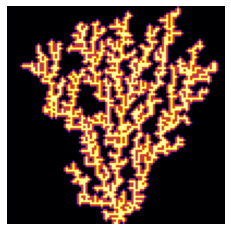

In [6]:
fig = plt.figure(frameon=False)

plt.imshow(aggregate,cmap=plt.cm.inferno)

#remove the axes ticks
for ax in fig.axes:
    ax.label_outer()
    ax.axis('off')

#save the plot
# plt.savefig("Figures/p_test01.png",format="png", dpi=300)